
___
# Using Random Forest on the Titanic Dataset

Using the train data from the Kaggle Titanic dataset located at https://www.kaggle.com/c/titanic, I would like to try using Random forest to predict the survival of passengers.

### Mike Bourne - Sept 2020



Importing the Libraries required for this project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Import the data and examining it

In [25]:
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

Explore the data and see if there are any missing data

<AxesSubplot:>

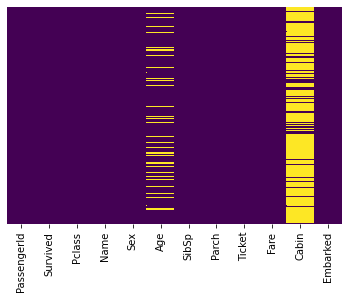

In [4]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

It looks like that quite a bit (~25%) of the Age data is missing - I will attempt to fill this in later using another parameter. 

Also most of the Cabin data is not present - this is probably not retreivable - I will need to drop this.

Next, I will create some visualisations to get an understanding of the dataset.


<AxesSubplot:xlabel='Survived', ylabel='count'>

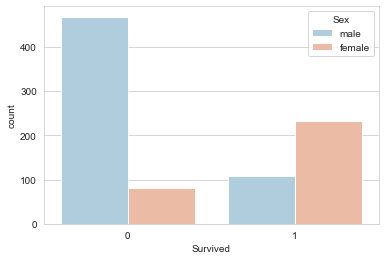

In [5]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

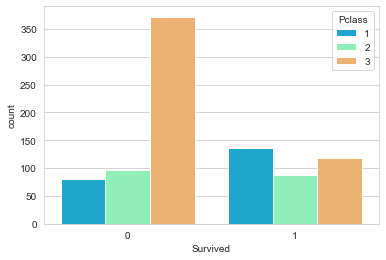

In [6]:
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

<AxesSubplot:xlabel='Age'>

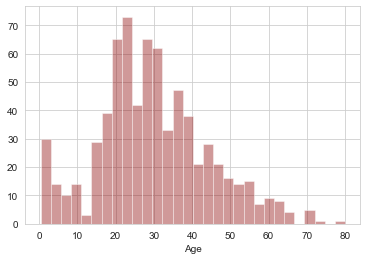

In [7]:
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

looks like most of the non survivers were male and in 3rd class. Women and first class passengers had a better change of surviving

<AxesSubplot:>

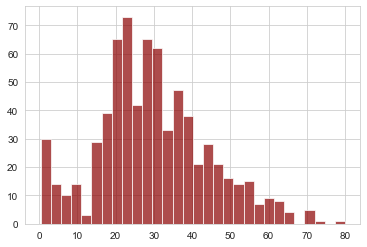

In [26]:
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

Most of the passengers were under the age of 35 and there were quite a few children onboard

<AxesSubplot:xlabel='SibSp', ylabel='count'>

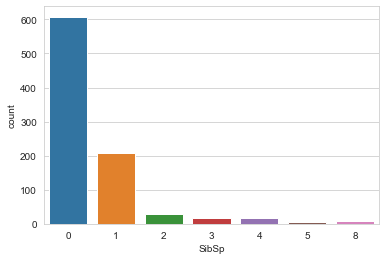

In [27]:
sns.countplot(x='SibSp',data=train)

Most passengers were on their own, or with a partner

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

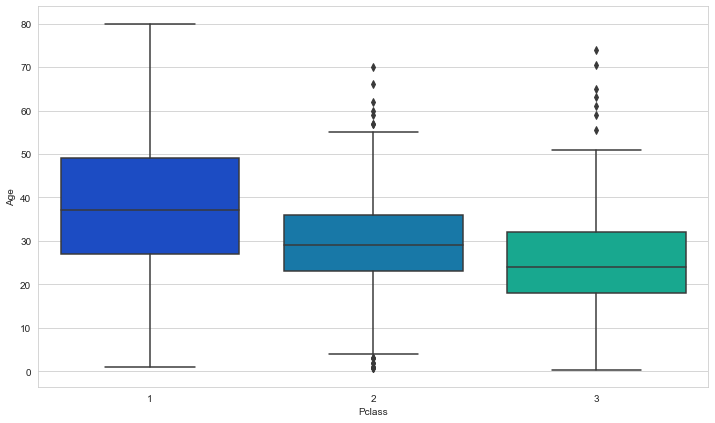

In [28]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Wealthier passengers in first class tend to be older than those in the lower classes.


Next, I will use this info to clean the Age data

In [29]:
# create an function to estimate the Age of the class, 
#    where Age is not present
def new_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    
    if pd.isnull(Age):   # runs when no age is present
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age   # return given Age if present
    
# Run this function and reassign to the Age column
train['Age'] = train[['Age','Pclass']].apply(new_age,axis=1)



Also removing the columns which I wont use in Random Forest

In [30]:
train.drop('Cabin',axis=1,inplace=True)
train.dropna(inplace=True)


Also I need to convert categorical features to dummy variables 

In [31]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [32]:
train.head(1)

PassengerId  Survived  Pclass                     Name   Sex   Age  SibSp  \
0            1         0       3  Braund, Mr. Owen Harris  male  22.0      1   

   Parch     Ticket  Fare Embarked  
0      0  A/5 21171  7.25        S

In [33]:
train.drop(['Sex','Embarked','Name','Ticket','PassengerId'],axis=1,inplace=True)

In [34]:
final_data = pd.concat([train,sex,embark],axis=1)

In [35]:
final_data.head()

Survived  Pclass   Age  SibSp  Parch     Fare  male  Q  S
0         0       3  22.0      1      0   7.2500     1  0  1
1         1       1  38.0      1      0  71.2833     0  0  0
2         1       3  26.0      0      0   7.9250     0  0  1
3         1       1  35.0      1      0  53.1000     0  0  1
4         0       3  35.0      0      0   8.0500     1  0  1


# Building the Random Forest model

Start by splitting the data into a training set and test set (from just the train.csv file provided on Kaggle)

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X = final_data.drop('Survived',axis=1)
y = final_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

Training the model

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=600)

Now predict on the split test data using the dtree model

In [40]:
predictions = rfc.predict(X_test)

Evaluate the model

In [41]:
from sklearn.metrics import classification_report,confusion_matrix

In [42]:
print('Confusion Matrix')
print('----------------')
print(confusion_matrix(y_test,predictions))
print('\n')
print('Classfication Report')
print('--------------------')
print(classification_report(y_test,predictions))

Confusion Matrix
----------------
[[141  22]
 [ 28  76]]


Classfication Report
--------------------
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       163
           1       0.78      0.73      0.75       104

    accuracy                           0.81       267
   macro avg       0.80      0.80      0.80       267
weighted avg       0.81      0.81      0.81       267



## Conclusions

The model is fairly good at predicting whether a passenger survived or not. 220 were correctly predicted. There were 27 FP and 20 FN, giving 47 incorrect predictions.